# Preprocessing Data
Before we start, we need to standardize the data by removing noise. To do this, we will use the [nilearn](https://nilearn.github.io/stable/index.html) library which is a python library for statistical learning on neuroimaging data. 

### Import dependencies


In [9]:
from nilearn import plotting, image
import matplotlib.pyplot as plt
%matplotlib inline

# Get the Node and Workflow object
from nipype import Node, Workflow, Function

# Specify which SPM to use
from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('/opt/spm12-r7219/spm12_mcr/spm12')
from nipype.algorithms.misc import Gunzip

# set up FSL environment
import os
output_dir = './output'
os.makedirs(output_dir, exist_ok=True)
os.environ['FSLDIR'] = '/usr/local/fsl' # set the FSL directory
os.environ['PATH'] = f"{os.environ['FSLDIR']}/bin:{os.environ['PATH']}" # add FSL to the PATH
os.environ['FSLOUTPUTTYPE'] = 'NIFTI' # set the output type

In [10]:
# initialize the functional file sample
func_file = '/Users/jaslavie/fMRI/data/ds102_R2.0.0/sub-07/func/sub-07_task-flanker_run-1_bold.nii.gz'

# Initiate Gunzip node to decompress the file
gunzip_func = Node(Gunzip(in_file=func_file), name='gunzip_func')

### visualize and clean data

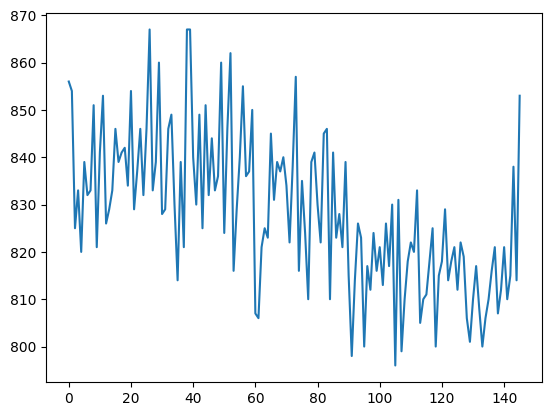

In [11]:
# plot a test voxel
import nibabel as nb
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(nb.load(func_file).get_fdata()[32, 32, 15, :])

### Clean Data

In [12]:
# Extract ROI using nilearn instead of FSL
from nilearn.image import index_img

# Create workflow
base_dir = './output'
preproc = Workflow(name='preproc_workflow', base_dir=base_dir)

def extract_roi(in_file, t_min=4):
    from nilearn import image 
    from nilearn.image import index_img 
    import os

    img = image.load_img(in_file)
    roi_img = index_img(img, slice(t_min, None))

    # save the extracted ROI to a temp file and return the path
    output_path = os.path.abspath('roi_extracted.nii')
    roi_img.to_filename(output_path)
    return output_path

# Initiate Gunzip function to create nodes
gunzip_func = Node(Gunzip(in_file=func_file), name='gunzip_func')

extract = Node(
    Function(
        input_names=['in_file', 't_min'],
        output_names=['roi_img'],
        function=extract_roi
    ),
    name='extract'
)
extract.inputs.t_min = 4 # extract the first 4 time points

### Slice Time Correction
Corrects the time at which each slice of the brain is acquired to standardize the timing of the scans.

In [13]:
# create a slice time node
from nipype.interfaces.fsl import SliceTimer
slicetime = Node(
    SliceTimer(
        interleaved=True,
        slice_direction=3,
        output_type='NIFTI'
    ),
    name='slicetime_correction'
)

# Connect nodes
preproc.connect([
    (gunzip_func, extract, [('out_file', 'in_file')]),
    (extract, slicetime, [('roi_img', 'in_file')])  # Changed to in_file for FSL
])

After processing, you can tell that the data is more uniform. 

241111-13:17:31,609 nipype.workflow INFO:
	 Workflow preproc_workflow settings: ['check', 'execution', 'logging', 'monitoring']
241111-13:17:31,614 nipype.workflow INFO:
	 Running serially.
241111-13:17:31,615 nipype.workflow INFO:
	 [Node] Setting-up "preproc_workflow.gunzip_func" in "/Users/jaslavie/fMRI/output/preproc_workflow/gunzip_func".
241111-13:17:31,618 nipype.workflow INFO:
	 [Node] Cached "preproc_workflow.gunzip_func" - collecting precomputed outputs
241111-13:17:31,620 nipype.workflow INFO:
	 [Node] "preproc_workflow.gunzip_func" found cached.
241111-13:17:31,621 nipype.workflow INFO:
	 [Node] Setting-up "preproc_workflow.extract" in "/Users/jaslavie/fMRI/output/preproc_workflow/extract".
241111-13:17:31,625 nipype.workflow INFO:
	 [Node] Cached "preproc_workflow.extract" - collecting precomputed outputs
241111-13:17:31,625 nipype.workflow INFO:
	 [Node] "preproc_workflow.extract" found cached.
241111-13:17:31,627 nipype.workflow INFO:
	 [Node] Setting-up "preproc_workflo

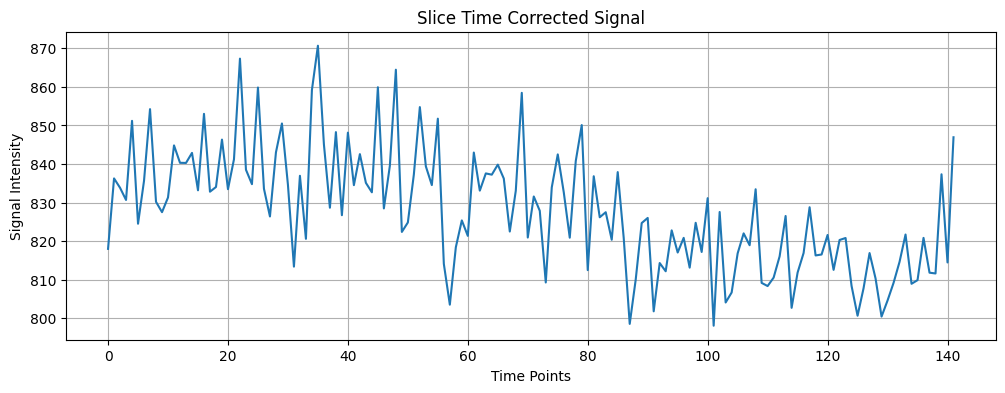

In [15]:
# run the workflow
preproc.run()

# plot the result
base_dir = 'output'
output_dir = os.path.join(base_dir, 'preproc_workflow', 'slicetime_correction')
result_file = preproc.get_node('slicetime_correction').result.outputs.slice_time_corrected_file
plt.figure(figsize=(12, 4))
plt.plot(nb.load(result_file).get_fdata()[32, 32, 15, :]) # plot a test voxel
plt.title('Slice Time Corrected Signal')
plt.xlabel('Time Points')
plt.ylabel('Signal Intensity')
plt.grid(True)
plt.show()
